In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50
from keras.callbacks import *
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img

Using TensorFlow backend.


In [2]:
import dlib
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import imutils
from imutils.face_utils import *
import os
from os import listdir
import pickle
import pandas as pd
import sys
import time

In [3]:
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
% matplotlib inline

In [4]:
#%%
global detector ,landmark_predictor
#宣告臉部偵測器，以及載入預訓練的臉部特徵點模型
detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('./face_model/shape_predictor_68_face_landmarks.dat')

#%% 臉部識別函數宣告
#讀取評分數據
rating_dict={}
with open('./All_labels.txt','rb') as label:
    datalines = label.readlines()
    for d in datalines:
        d = str(d).replace('b','').replace('\\n','').replace("'","").split(' ')
        rating_dict[d[0]] = float(d[1])  
        
def get_face(img):
    #產生臉部識別
    face_rects = detector(img, 1)
    for i, d in enumerate(face_rects):
        #讀取框左上右下座標
        x1 = d.left()
        y1 = d.top()
        x2 = d.right()
        y2 = d.bottom()
        #根據此座標範圍讀取臉部特徵點
        shape = landmark_predictor(img, d)
        #將特徵點轉為numpy
        shape = shape_to_np(shape)# (68,2)    
        # 透過dlib挖取臉孔部分，將臉孔圖片縮放至256*256的大小，並存放於pickle檔中
        # 人臉圖像部分呢。很簡單，只要根據畫框的位置切取即可crop_img = img[y1:y2, x1:x2, :]
        crop_img = img[y1:y2, x1:x2, :]   
        try:
            crop_img = cv2.resize(crop_img, (128, 128))         
            return crop_img   
        except:
            return np.array([0])  
    return np.array([0])         

In [5]:
#%% 顏值特徵擷取
def load_dataset():  
    files = './Images'
    image_data_list = []
    label = []
    start = time.time()
    # 以迴圈處理
    error = []
    for idx,f in enumerate(os.listdir(files)):
        # 產生檔案的絕對路徑
        fullpath = os.path.join(files, f)
        img = cv2.imread(fullpath)
        face = get_face(img)
        if (face.shape != (1,)) :
            image_data_list.append(img_to_array(face))
            label.append(rating_dict[f]) 
        else:
            error.append(f)
            print(fullpath)
        if (idx%100==0)and (idx>0):        
            print("{} detect success , use time:{:2f}s".format(idx - len(error),time.time() - start))
        del fullpath,img,face
        
    img_data = np.array(image_data_list)
    img_data = img_data.astype('float32')
    img_data /= 255        
    return img_data, label 

In [6]:
#%% DataSet輸出為npz檔
if not os.path.exists('./Image.npz'):
    train_x, train_y = load_dataset()
    train_x.shape
else:
    ds = np.load('./Image.npz')
    train_x,train_y = ds['data'],ds['label']
    len(rating_dict.keys())


np.savez('./Image.npz', data=train_x, label=train_y)
ds = np.load('./Image.npz')
train_x,train_y = ds['data'],ds['label']
train_y = np.array(train_y)
len(train_y)

5483

([<matplotlib.axis.XTick at 0x23cb82cfc88>,
 <a list of 9 Text xticklabel objects>)

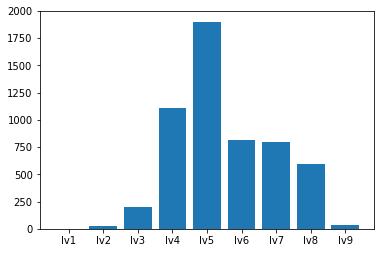

In [7]:
#%% 查看顏值分布情況
scores = list(train_y)
lv1 = [x for x in scores if x<1]
lv2 = [x for x in scores if x>=1 and x<1.5]
lv3 = [x for x in scores if x>=1.5 and x<2]
lv4 = [x for x in scores if x>=2 and x<2.5]
lv5 = [x for x in scores if x>=2.5 and x<3]
lv6 = [x for x in scores if x>=3 and x<3.5]
lv7 = [x for x in scores if x>=3.5 and x<4]
lv8 = [x for x in scores if x>=4 and x<4.5]
lv9 = [x for x in scores if x>=4.5]
lv = [1,2,3,4,5,6,7,8,9]
lv_label = ['lv1','lv2','lv3','lv4','lv5','lv6','lv7','lv8','lv9']
len_lv = [len(x) for x in [lv1,lv2,lv3,lv4,lv5,lv6,lv7,lv8,lv9]]
plt.bar(lv,len_lv)
plt.xticks(lv, lv_label)

In [21]:
#%%
seed = 42
x_train_all, x_test, y_train_all, y_test = train_test_split(train_x, np.array(train_y), test_size=0.2, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=seed)

import tensorflow as tf
def correlation_coefficient(y_true, y_pred):
    pearson_r, _ = tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)
    return 1-pearson_r**2

from scipy import stats

#%%
def make_network():
    resnet = ResNet50(include_top=False, pooling='avg', input_shape=(128, 128, 3))
    model = Sequential()
    model.add(resnet)
    model.add(Dense(1))
    model.layers[0].trainable = True
    model.compile(loss='mse', optimizer='Adam',metrics=['accuracy'])
#     model.compile(loss = correlation_coefficient, optimizer='Adam',metrics=['accuracy'])
#     model.compile(loss = stats.pearsonr, optimizer='Adam',metrics=['accuracy'])
    model.summary()
    return model

In [28]:
model = make_network()

#%% 模型訓練
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience = 10, 
    verbose = 0, 
    mode='auto'
)

filepath="{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callback_list = [checkpoint, reduce_learning_rate,early_stopping]

train_history = model.fit(x_train, y_train, 
                          batch_size=8, epochs=30, verbose=1, 
                          validation_split=0.2,
                          validation_data=(x_val, y_val),
                          callbacks = callback_list)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
Train on 3508 samples, validate on 878 samples
Epoch 1/30
3508/3508 [==============================] - 102s 29ms/step - loss: 0.6633 - acc: 0.0080 - val_loss: 0.3688 - val_acc: 0.0068

Epoch 00001: val_loss improved from inf to 0.36879, saving model to 01-0.37.h5
Epoch 2/30
3508/3508 [==============================] - 91s 26ms/step - loss: 0.2012 - acc: 0.0103 - val_loss: 0.2677 - val_acc: 0.0114

Epoch 00002: val_loss improved from 0.36879 to 0.26772, saving model to 02-0.27.h5
Epoch 3/30
3508/3508 [===============

In [29]:
#%% 模型評估
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()  

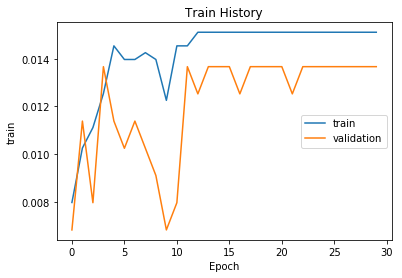

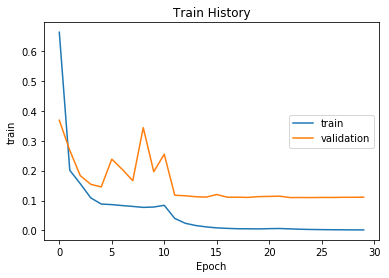

1097/1097 [==============================] - 6s 5ms/step


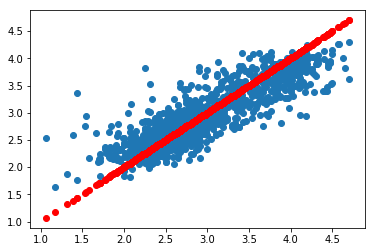

In [30]:
show_train_history(train_history, 'acc','val_acc')
show_train_history(train_history, 'loss','val_loss')
model.evaluate(x_test,y_test)
#%%
plt.scatter(y_test,model.predict(x_test))
plt.plot(y_test,y_test,'ro')
#%% 儲存模型%權重
# Save model
model.save('./faceRank.h5')
model.save_weights('./faceRank_weights.h5')
del model
from keras.models import load_model
global model
model = load_model('./faceRank.h5')
model.load_weights('./faceRank_weights.h5')

In [31]:
#%% 目標顏值預測
def predict_image(img_url):
    try:
        image = cv2.imread(img_url)
        face = get_face(image)
        face = face.astype('float32')
        face /= 255  
        print(face.shape)
        image = img_to_array(face)
        img = image[np.newaxis,:,:]
        plt.axis('off')
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        print("Predict Score : {}".format(model.predict(img)[0][0] * 20))  
    except Exception as e :
        print(e)
        print('臉部辨識失敗')

(128, 128, 3)
Predict Score : 41.70908451080322
(128, 128, 3)
Predict Score : 60.39839267730713
(128, 128, 3)
Predict Score : 64.27641868591309
(128, 128, 3)
Predict Score : 46.824235916137695


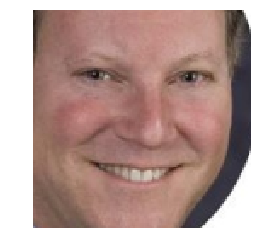

In [32]:
#%%
files = './Images'
for idx,f in enumerate(os.listdir(files)[-5:-1]):
    # 產生檔案的絕對路徑
    fullpath = os.path.join(files, f)
    predict_image(fullpath)

(128, 128, 3)
Predict Score : 62.73555278778076
(128, 128, 3)
Predict Score : 67.98409461975098
(1,)
Unsupported image shape: (1,)
臉部辨識失敗


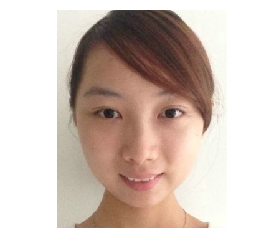

In [33]:
#%%
files = './TestImages'
for idx,f in enumerate(os.listdir(files)):
    # 產生檔案的絕對路徑
    fullpath = os.path.join(files, f)
    img = load_img(fullpath)
    plt.imshow(img)
    predict_image(fullpath)